In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import RepeatVector, TimeDistributed

import sqlite3 as sql
import seaborn as sns
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

In [2]:

warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [3]:
def split_dataset(data, test_size=60, predict_window=7):
    '''
    
    '''
    train, test = data[1:-test_size], data[-test_size:-(predict_window-1)]
#     train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
#     test = np.array(np.split(test, len(test)/7))
    return train, test


In [4]:
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
#     data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(train)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(train):
            # 训练数据以滑动步长1截取
#             train_seq = data[in_start:in_end, 0]
#             train_seq = train_seq.reshape((len(train_seq), 1))
#             X.append(train_seq)
#             y.append(data[in_end:out_end, 0])
            X.append(train[in_start:in_end, :])
            y.append(train[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

In [5]:
def lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', 
                   input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
#     model = Sequential()
#     model.add(LSTM(200, activation='relu',
#                    input_shape=(n_timesteps, n_features)))
#     model.add(RepeatVector(n_outputs))
#     model.add(LSTM(200, activation='relu', return_sequences=True))
#     model.add(TimeDistributed(Dense(100, activation='relu')))
#     model.add(TimeDistributed(Dense(1)))
    
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    
    
    history = model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model, history

In [6]:
def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    mse = skm.mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    error = rmse / len(actual)
   
    print('average RMSE:' , error)
    return error


In [7]:
def summarize_scores(name, error):
    print('%s: [%.3f] \n' % (name, error))


In [8]:
def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
#     data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
#     input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
#     input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    input_x = data[-sw_width:, :]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) # 重塑为[1, n_input, n]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

In [9]:
def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = train
    test_x, test_y = sliding_window(test, sd_width, in_start=0)
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test_x)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore = np.append(history_fore, [test[i]], axis=0) # 

    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
#     print(predictions)
    error = evaluate_forecasts(test_y[:, 0], predictions[:, 0])
    return error, test_y[:, 0], predictions[:, 0]

In [10]:
def model_plot(actual, predict, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(actual, marker='o', label="actual")
    plt.plot(predict, marker='x', label="predicated")
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$Price$', size=15)
    plt.title('LSTM Bitcoin Predication Result',  size=18)
    plt.legend()
    plt.show()

In [11]:
def main_run(dataset, sw_width, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset)
    # 训练模型
    model, history = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    error, actual, predict = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, error)
    # 绘图
    model_plot(actual, predict, name)
    
    
# plot train and validation loss
    plt.figure(figsize=(8,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper right')
    plt.show()
   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               166400    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 187,207
Trainable params: 187,207
Non-trainable params: 0
_________________________________________________________________
None
average RMSE: 84.32435497409367
LSTM: [84.324] 



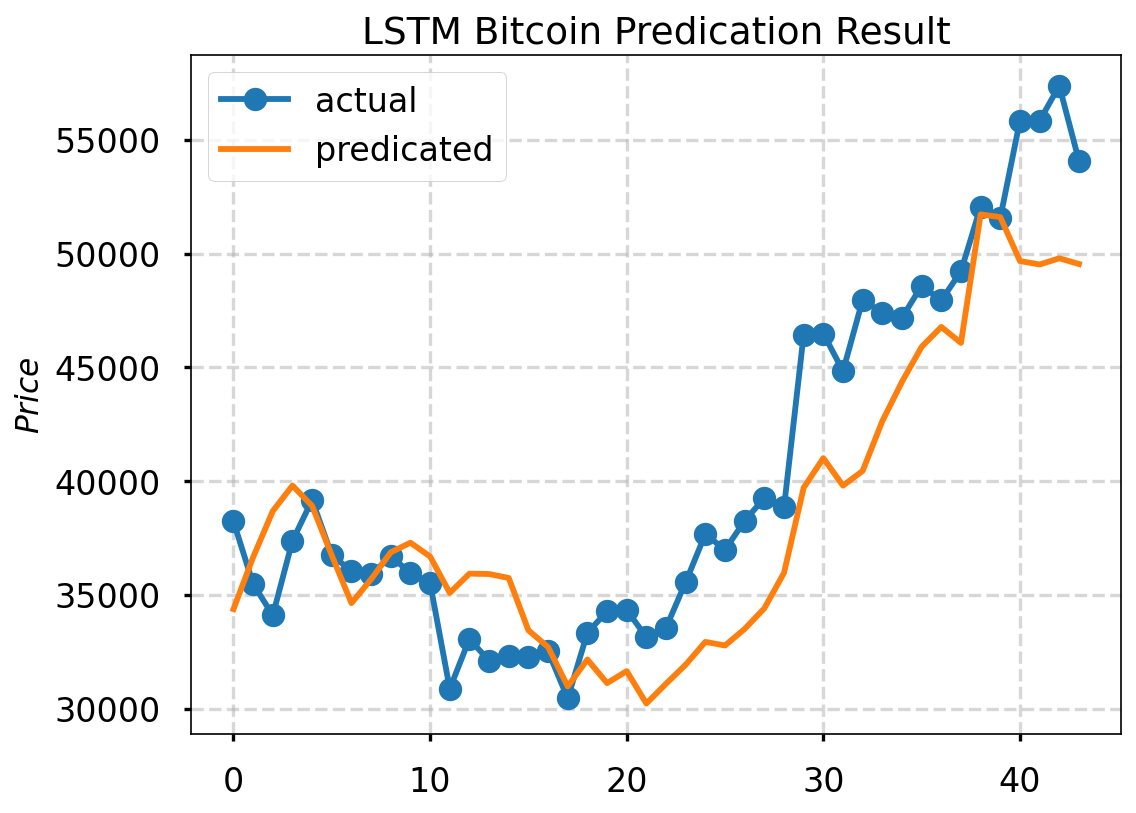

KeyError: 'val_loss'

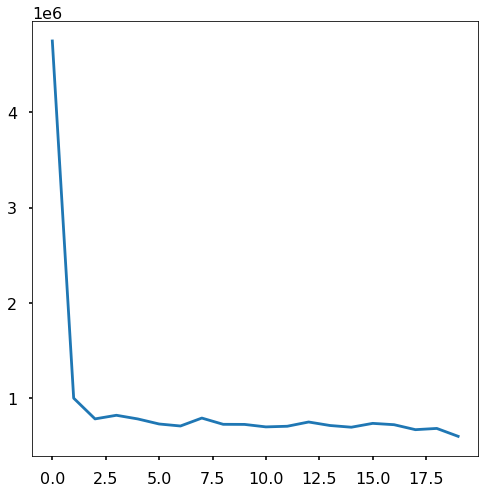

In [12]:
if __name__ == '__main__':
    
#     dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
#                    infer_datetime_format=True, engine='c',
#                    parse_dates=['datetime'], index_col=['datetime'])
    con = sql.connect("./data/paperdb.db")
    SQL_BTC_USD_TRAIN = """
        select 
        btc.date
        ,btc."close" as btc_price
        ,eu."close" as euro_price
        ,gu."close" as gold_price
        ,uc."close" as cny_price
        ,s2."close" as sp_price
        ,s."close" as sh_price
        ,bi.search_cnt 
        from BTC_USD btc
        left outer join EUR_USD eu on btc.date = eu.date 
        left outer join GOLD_USD gu on btc.date = gu.date 
        left outer join USD_CNH uc on btc.date = uc.date 
        left outer join SP500 s2 on btc.date = s2.date 
        left outer join SHSTOCK s on btc.date = s.date 
        left outer join BAIDU_INDEX bi on btc.date = bi.date 
        where btc.date>='2016-01-04'  order by btc.date asc
    """
    btc_usd = pd.read_sql(SQL_BTC_USD_TRAIN, con)
    btc_usd = btc_usd.fillna(method='ffill')
    btc_usd.Timestamp = pd.to_datetime(btc_usd.date)
    # Resampling to daily frequency
    btc_usd.index = btc_usd.Timestamp
    del btc_usd['date']
    dataset = btc_usd.values.astype('float64')

#     train, test = split_dataset(dataset.values.astype('float64'))
    
    name = 'LSTM'
    
    sliding_window_width= 3
    input_sequence_start=0
    
    epochs_num=50
    batch_size_set=16
    verbose_set=1
    
    
    main_run(dataset, sliding_window_width, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)
    
    